# Word Embedding Models: word2vec #

*Lauren F. Klein wrote version 1.0 of this notebook based on the [Advanced Topics in Word Vectors workshop](https://dh2018.adho.org/en/machine-reading-part-ii-advanced-topics-in-word-vectors/) at DH 2018 as well as tutorials by [Radim Rehurek](https://rare-technologies.com/word2vec-tutorial/) and [Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)** 

## Why word2vec?

At the beginning of this unit, we were introduced to the idea of turning texts into numbers through word vectors. In 2013, Tomas Mikolov and his team at Google used that idea to create word2vec, a word embedding model that is powerful for analyzing text. It is one method for predicting what word is likely to come next in a text; it also allows the exploration of similarity and analogy between words in a corpus. 

We'll be using gensim, a Python library, to use word2vec today.

## Install gensim

In [1]:
# gensim is already installed on JupyterHub
#!pip install --upgrade gensim

## Import gensim, nltk tokenizers, glob, and Path

In [2]:
import gensim # remember this! 
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer
import nltk
nltk.download('punkt')
import glob
from pathlib import Path

[nltk_data] Downloading package punkt to /Users/dsinyki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read in our corpus

In [3]:
# next, we need to create our corpus.
# we will continue to use the NYT obituaries corpus

import os

base_dir = "../docs/NYT-Obituaries/" 

all_docs = [] # our list which will store the text of each doc; empty for now

docs = os.listdir(base_dir) # get a list of all the files in the directory

for doc in docs: # iterate through the docs
    if not doc.startswith('.'): # get only the .txt files
        with open(base_dir + doc, "r", encoding="utf-8") as file: # force unicode conversion to keep PCs happy
            text = file.read() # read in the file as a single text string
            all_docs.append(text) # append it to the all_docs list

# lastly, just check the length of all_docs to see if it's 147
len(all_docs)

378

## Preprocessing

gensim takes text at the level of `sentences` as its input. 

So let's define a function that a takes a list of texts (e.g. our all_docs list) and converts it into sentences for gensim word2vec to use. The function will lower-case text and tokenize by sentence and word.

In [4]:
# need our handy nltk tokenizer 
tokenizer = TreebankWordTokenizer()

# and we'll get titles
directory = "../docs/NYT-Obituaries/"
files = glob.glob(f"{directory}/*.txt")
obit_titles = [Path(file).stem for file in files]

# and the function
def make_sentences(list_txt):
    all_txt = []
    counter = 0
    for txt in list_txt:
        lower_txt = txt.lower()
        sentences = sent_tokenize(lower_txt)
        sentences = [tokenizer.tokenize(sent) for sent in sentences]
        all_txt += sentences
        print(obit_titles[counter]) # let's print the title of the obit
        print(len(sentences))  # let's check how many sentences there are per obit
        print("\n")
        counter += 1
    return all_txt

In [5]:
# now let's run it
sentences = make_sentences(all_docs)

1945-Adolf-Hitler
597


1915-F-W-Taylor
15


1975-Chiang-Kai-shek
240


1984-Ethel-Merman
110


1953-Jim-Thorpe
79


1964-Nella-Larsen
44


1955-Margaret-Abbott
52


1984-Lillian-Hellman
159


1959-Cecil-De-Mille
65


1928-Mabel-Craty
14


1973-Eddie-Rickenbacker
125


1989-Ferdinand-Marcos
53


1991-Martha-Graham
118


1997-Deng-Xiaoping
274


1938-George-E-Hale
31


1885-Ulysses-Grant
1619


1909-Sarah-Orne-Jewett
20


1957-Christian-Dior
43


1987-Clare-Boothe-Luce
94


1976-Jacques-Monod
41


1954-Getulio-Vargas
56


1979-Stan-Kenton
58


1990-Leonard-Bernstein
203


1972-Jackie-Robinson
164


1998-Fred-W-Friendly
81


1991-Leo-Durocher
44


1915-B-T-Washington
54


1997-James-Stewart
101


1981-Joe-Louis
156


1983-Muddy-Waters
38


1942-George-M-Cohan
160


1989-Samuel-Beckett
160


1962-Marilyn-Monroe
84


2000-Charles-M-Schulz
296


1967-Gregory-Pincus
59


1894-R-L-Stevenson
106


1978-Bruce-Catton
8


1982-Arthur-Rubinstein
174


1875-Andrew-Johnson
103


1974-Charles-Lindber

1948-Babe-Ruth
220


1947-Willa-Cather
39


1963-John-F-Kennedy
98


1975-Walker-Evans
47


1916-J-J-Hill
197


1980-Jesse-Owens
107


1948-Sergei-Eisenstein
19


1981-Robert-Moses
186


1989-Robert-Penn-Warren
84


1901-William-McKinley
161


1970-Walter-Reuther
23


1930-Balfour
141


1984-Indira-Gandhi
309


1978-Golda-Meir
242


1983-Earl-Hines
25


1974-Katharine-Cornell
102


1982-Lee-Strasberg
86


1939-Pope-Pius-XI
112


1886-Mary-Ewing-Outerbridge
49


1993-Dizzy-Gillespie
95


1910-Florence-Nightingale
75


1960-Richard-Wright
36


1986-The-Challenger
38


1992-Menachem-Begin
150


1998-Galina-Ulanova
32


1976-Max-Ernst
98


1993-Cesar-Chavez
78


1965-Adlai-Ewing-Stevenson
187


1935-Adolph-S-Ochs
446


1941-Lou-Gehrig
8


1961-Carl-G-Jung
92


1963-Robert-Frost
108


1965-Edward-R-Murrow
197


1971-Dean-Acheson
166


1986-Jorge-Luis-Borges
102


1966-Walt-Disney
142


1996-Carl-Sagan
58


1959-Ross-G-Harrison
14


1945-Jerome-Kern
62


1991-Frank-Capra
69


1987-Andres-Seg

## Train model

Now that we have our corpus ready for gensim, we can train the model. To do so, we call the function `gensim.models.Word2Vec()`. This function has a couple dozen parameters, some of which are more important than others.

Here are a few major ones. Only two are MANDATORY: these are marked with an asterisk:

1. `sentences*`: This is where you provide your data. It must be in a format of iterable of iterables.
2. `sg`: Your choice of training algorithm. There are two standard ways of training W2V vectors -- 'skipgram' and 'CBOW'. If you enter 1 here the skip-gram is applied; otherwise, the default is CBOW.
3. `size*`: This is the length of your resulting word vectors. If you have a large corpus (>few billion tokens) you can go up to 100-300 dimensions. Generally word vectors with more dimensions give better results.
4. `window`: This is the window of context words you are training on. In other words, how many words come before and after your given word. A good number is 4 here but this can vary depending on what you are interested in. For instance, if you are more interested in embeddings that embody semantic meaning, smaller window sizes work better. 
5. `alpha`: The learning rate of your model. If you are interested in machine learning experimentation with your vectors you may experiment with this parameter.
6. `seed` (int): This is the random seed for your random initialization. All deep learning models initialize the weights with random floats before training. This is a useful field if you want to replicate your experiments because giving this a seed will initialize 'randomly' deterministically.
7. `min_count`: This is the minimum frequency threshold. If a given word appears with lower frequency than provided it will be ignored. This is here because words with very low frequency are hard to train.
8. `iter`: This is the number of iterations(entire run) over the corpus, also known as epochs. Usually anything between 1-10 is ok. The trade offs are that if you have higher iterations, it will take longer to train and the model may overfit on your dataset. However, longer training will allow your vectors to perform better on tasks relevant to your dataset.

Most of these settings will not concern us. As you'll see below, we are only going to use four arguments.

In [6]:
# let's train our model!
obit_model = gensim.models.Word2Vec(
    sentences,
    min_count=2, # default is 5; this trims the corpus for words only used once; 
    size=200, # size of NN layers; default is 100; higher for larger corpora
    workers=5) # parallel processing; needs Cython

Hooray! We have a trained word2vec model: `obit_model`!

## Save model — and load it

It's often useful to save your trained model to disk so that you can reload it as needed. 

In [ ]:
obit_model.save('obit_model')

And you can load a model in the same way (remember this from our topic model)

In [ ]:
old_model = gensim.models.Word2Vec.load('obit_model') 

## What's in the model?

The method `wv.vocab` allows us to see the words in our model

In [7]:
# take a quick look at the vocab
obit_model.wv.vocab

{'may': <gensim.models.keyedvectors.Vocab at 0x7f9f0efd9850>,
 '2': <gensim.models.keyedvectors.Vocab at 0x7f9f0a3a8410>,
 ',': <gensim.models.keyedvectors.Vocab at 0x7f9f0a3b2d10>,
 '1945': <gensim.models.keyedvectors.Vocab at 0x7f9f0ef96410>,
 'obituary': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03d950>,
 'hitler': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03d9d0>,
 'fought': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03da10>,
 'way': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03da50>,
 'to': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03d890>,
 'power': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03d910>,
 'unique': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03da90>,
 'in': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03dad0>,
 'modern': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03db10>,
 'history': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03db50>,
 'by': <gensim.models.keyedvectors.Vocab at 0x7f9f0f03db90>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f9f0f

## Let's play!

### Similarity

Adolf Hitler has one of the longest obits in the corpus. word2vec can tell us which words, according to its model, are most similar to any other. We call `model.wv.most_similar("word", topn=number of similar words)`. Let's try `hitler`

In [8]:
# testing some basic functions

# basic similarity
obit_model.wv.most_similar("hitler", topn=10)

[('stalin', 0.9436033964157104),
 ('mao', 0.926986038684845),
 ('lenin', 0.914769172668457),
 ('ho', 0.9062485098838806),
 ('soprano', 0.8869476914405823),
 ('segovia', 0.8853384256362915),
 ('1824', 0.8807531595230103),
 ('m-g-m', 0.8777264952659607),
 ('ernst', 0.8767301440238953),
 ('franco', 0.8766900300979614)]

Let's think about the results. `stalin` and `mao` make intuitive sense: they are the two mid-twentieth-century authoritarian figures most often compared to Hitler. But what's `irgun`? It's the name of a Zionist paramilitary organization, designated as a terrorist organization by the United Nations, that existed from 1933-1948, during Hitler's rise and fall, and which used violent means to make way for Jews in Palestine by forcing out Palestinians. Our model's parallel invites our critical analysis: rather than take these results as *true*, we need to reflect, in part through turning to obits themselves and close reading them, on how the model arrives at its results, and what they might imply.

**Remember**: everything the model knows it knows from our corpus. What we're learning are assumptions *immanent* to the corpus.

We can choose specific words to compare with `model.wv.similarity(w1="word_one",w2="word_two")`

Let's try with two of Hitler's contemporaries: Marilyn Monroe and Charles Lindbergh. The latter was a famous pilot who was also a Nazi sympathizer and briefly contemplated a political career, a possibility pursued in the counterfactual novel, *The Plot Against America*, which became an HBO show of the same name.

In [9]:
# similarity b/t two words

print(obit_model.wv.similarity(w1="hitler",w2="marilyn"))
print(obit_model.wv.similarity(w1="hitler",w2="lindbergh"))

0.6260597
0.87227595


As expected, the model believes Lindbergh is more similar to Hitler than Monroe.

### Analogy

We can also play with analogy tasks. The commonly seen task is:

'Man is to King as Woman is to ____?'

The general structure is:
`A is to A\*  as  B is to B\*`
                         
gensim provides two different ways of implementing this task. You may be familiar with the the additive version also called the 3CosAdd method:

$$\underset{b*\in V}{\textrm{arg max}} (cos(b*,b) - cos(b*,a) + cos(b*,a*))$$

This reflects the abstraction of Woman - Man + King. In this maximization, we are searching which word vector will allow us to produce the highest value in this equation.

We can implement this method with a built-in function. Positive here refers to words that give the positive contribution to similarity (nominator), and negative refers to words that contribute negatively (denominatory). Here's the additive method.

In [10]:
# analogies
# format is: "man is to president as woman is to ???"

result = obit_model.wv.most_similar(positive=['woman', 'president'], negative=['man'])
print("{}: {:.4f}".format(*result[0])) # this prints the top result

secretary: 0.9030


Man is to woman as president is to...secretary!? Ah, the bias of the model....

## There's so much more!

gensim has quite a few built-in tools, and it's worth taking some time to see what's available. Check the documentation here: [https://radimrehurek.com/gensim/models/keyedvectors.html](https://radimrehurek.com/gensim/models/keyedvectors.html)


## Your turn!

Play with word2vec in the code cells below, following the prompts.

In [11]:
# choose a word and find the 10 words most similar to it

obit_model.wv.most_similar("marilyn", topn=10)

[('sarah', 0.984088659286499),
 ('krebs', 0.9830100536346436),
 ('conan', 0.9822401404380798),
 ('johnny', 0.9812618494033813),
 ('albin', 0.9808303117752075),
 ('shirley', 0.9805138111114502),
 ('orson', 0.9801497459411621),
 ('birth-control', 0.9792305827140808),
 ('van', 0.9786124229431152),
 ('gene', 0.9783428907394409)]

Do the results above make sense? Reflect on them. How does attention to the corpus—its particular qualities—help explain what seems to work and what is harder to make sense of?

#### ANSWER HERE

In [21]:
# build an analogy after the model "Man is to King as Woman is to ___". Try with various possibilities.

result = obit_model.wv.most_similar(positive=['man', 'politics'], negative=['woman'])
print("{}: {:.4f}".format(*result[0])) # this prints the top result

possible: 0.8554


In my experimenting, I found that analogies often don't work terribly well with this corpus. Did they work for you? Why, do you think?

The corpus is too small for word2vec to work well

In [23]:
# investigate the documentation—https://radimrehurek.com/gensim/models/keyedvectors.html—
# and choose a method we haven't yet explored in this notebook

print(obit_model.doesnt_match("hitler mao marilyn stalin".split()))

marilyn


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## BONUS: Visualization

Find below some code you can use to make visualizations from your word2vec model. We can't visualize all the many dimensions in our model, so we need to reduce them to two dimensions for our meager human brains. We do that with something called principal component analysis (PCA). 

Don't worry about the details for now. This is just a fun way to take a look at the output of our model. 

**Remember**: Our visualization reduces MANY dimensions to two, so a lot of information is lost.

In [24]:
### Let's do some visualization ###

import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [25]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


<IPython.core.display.Javascript object>


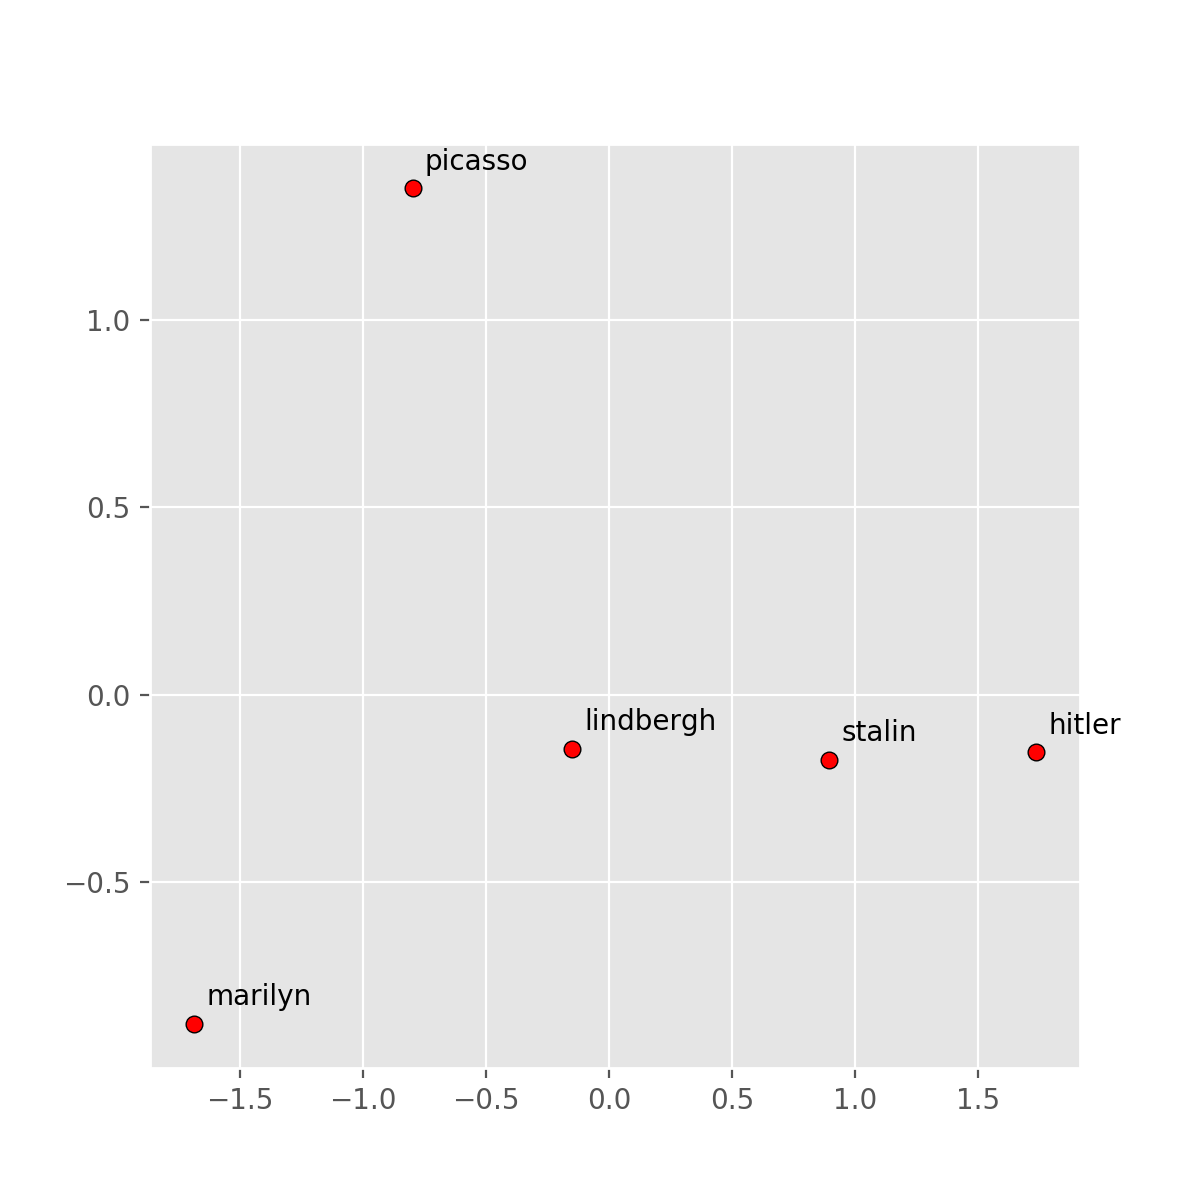

In [26]:
display_pca_scatterplot(obit_model, ['hitler','stalin','lindbergh','marilyn','picasso'])

# display_pca_scatterplot(ccp_model, sample=20)